In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Library

In [0]:
import torch
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, SubsetRandomSampler
from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data and Get Insight

In [0]:
root_folder = '/content/drive/My Drive/Colab Notebooks/mineral/minet'
target_label = ['biotite', 'bornite', 'chrysocolla', 'malachite', 
                'muscovite', 'pyrite', 'quartz']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
#load data and tranform it into tensor
dataset = ImageFolder(root_folder, transform=transforms.ToTensor())
print('Data size: ',len(dataset))
dataset.classes

Data size:  956


['biotite',
 'bornite',
 'chrysocolla',
 'malachite',
 'muscovite',
 'pyrite',
 'quartz']

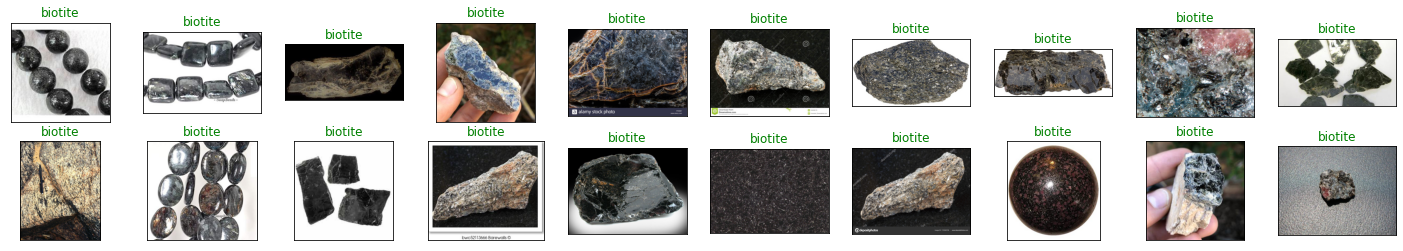

In [0]:
#check images of the dataset for first 20 images
fig = plt.figure(figsize=(25, 4))

for i in range(20):
    image, label = dataset[i]
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

In [0]:
#count number for each label
count = {}

for i in range(len(dataset)):
    _, labels = dataset[i]
    label = target_label[labels]
    if label not in count:
        count[label] = 1
    elif label in count:
        count[label] += 1

#insert count into dataframe
df = pd.DataFrame(count, index=np.arange(1))
df = df.transpose().reset_index()
df.columns = ['Mineral', 'count']
df

,Mineral,count
0,biotite,68
1,bornite,170
2,chrysocolla,163
3,malachite,235
4,muscovite,77
5,pyrite,98
6,quartz,145


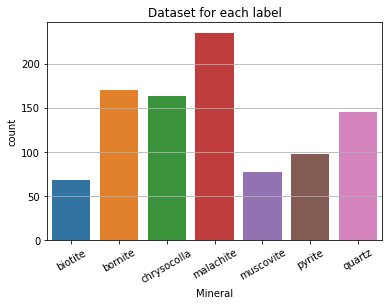

In [0]:
#plot barplot for the sake of easy to read
sns.barplot(df['Mineral'], df['count'])
plt.title('Dataset for each label');
plt.xticks(rotation=30)
plt.grid(axis='y')

In [0]:
#check image size for all datasets
# torch.FloatTensor of shape (C x H x W) 
height = []
weight = []
for i in range(len(dataset)):
    image, label = dataset[i]
    height.append(image.size(1))
    weight.append(image.size(2))
print(f"maximum_height:{np.max(height)} \tminimum_height:{np.min(height)} \tmean_height:{np.mean(height)}")
print(f"maximum_weight:{np.max(weight)} \tminimum_weight:{np.min(weight)} \tmean_weight:{np.mean(weight)}")

maximum_height:6016 	minimum_height:129 	mean_height:696.7426778242677
maximum_weight:6016 	minimum_weight:144 	mean_weight:806.3995815899582


# Data Loader

## Load All Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

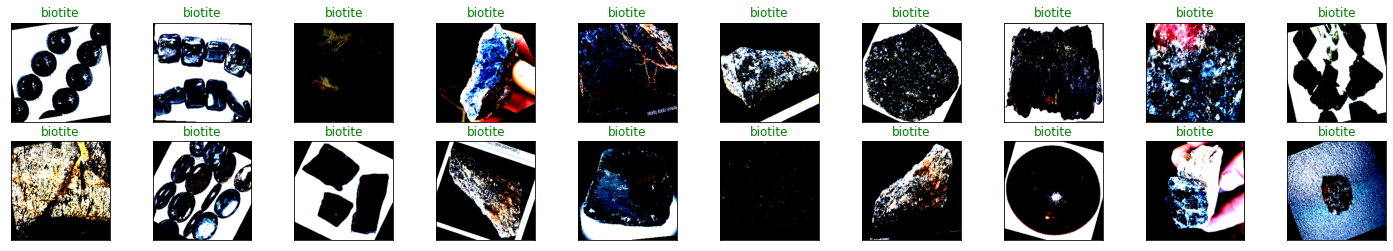

In [0]:
#transform format to augmetation dataset beacuse our dataset only has 956 images
#I reload the data and do multiple transformation and resize 
data_transform = transforms.Compose([transforms.Resize((224, 224)), 
                                     transforms.RandomRotation(30), 
                                     transforms.RandomVerticalFlip(p=0.5),
                                     transforms.RandomHorizontalFlip(p=0.5),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])]) #imagenet mean and std

load_data = ImageFolder(root_folder, transform=data_transform)

#check the images result from transformation
fig = plt.figure(figsize=(25, 4))
for i in range(20):
    image, label = load_data[i]
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks = [])
    ax.imshow(image.permute(1,2,0))
    ax.set_title(target_label[label], color='green')

## Split Data

In [0]:
# split base on random_split

# #ration for data split
# train_ratio = 0.90 
# train_size = int(len(load_data)*train_ratio) #90% data training
# val_size = int((len(load_data) - train_size) * 0.5)  #5% validation
# test_size = len(load_data) - (train_size + val_size) #5% testing

# datasize = len(load_data)
# data_idx = [x for x in range(datasize)]

# np.random.seed(97)
# np.random.shuffle(data_idx)

# train_idx = data_idx[:train_size]
# val_idx = data_idx[train_size:-test_size]
# test_idx = data_idx[train_size+val_size:]
# # #split data into 3 parts train, validation and testing
# # #train_set, val_set, test_set = random_split(load_data, [train_size, val_size, test_size])
# print('size of training data: ', len(train_idx))
# print('size of validation data: ', len(val_idx))
# print('size of test data: ', len(test_idx))

In [0]:
def plot_dist(indexes, dataset=dataset):
    #dist = {}
    count = Counter()
    for i in indexes:
        _, label = dataset[i]
        count[target_label[label]] += 1
    
    dist_2 = dict(sorted(count.items(), key=lambda kv: kv[1], reverse=True))
    plt.bar(dist_2.keys(), dist_2.values())
    plt.xticks(rotation=30)
    plt.title('Data distribution'); plt.ylabel('count')
    plt.show()

In [0]:
# split data to get the same distributiom


#get index and its label
idx_label = {}
for i in range(len(dataset)):
    _, label = dataset[i]
    idx_label[i] = label

#split for data validation
x_train, x_val, y_train, y_val = train_test_split(list(idx_label.keys()), list(idx_label.values()), 
                                                  stratify = list(idx_label.values()), test_size=0.05)



In [0]:
#exclude validation index from dataset
x_val
idx_label_2 = {}
for idx, label in idx_label.items():
    if idx not in x_val:
        idx_label_2[idx] = label

#split data train and test after exlude x_val
x_train, x_test, y_train, y_test = train_test_split(list(idx_label_2.keys()), list(idx_label_2.values()),
                                                    stratify = list(idx_label_2.values()), test_size=0.05)
print(len(x_train))
print(len(x_val))
print(len(x_test))

862
48
46


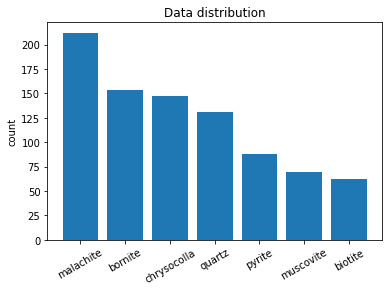

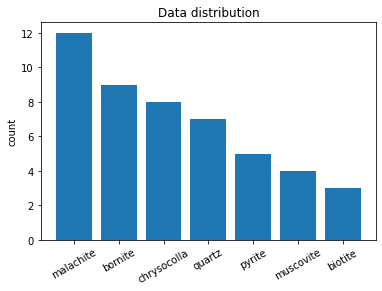

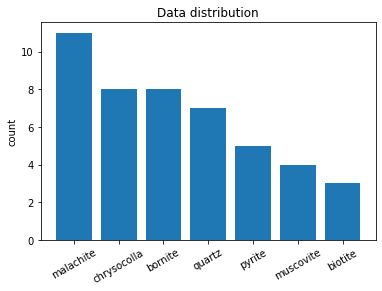

In [0]:
plot_dist(x_train)
plot_dist(x_val)
plot_dist(x_test)

In [0]:
#load into dataloader for each data after split it
batch_size = 128

#using subset to get data from indexes with the same distribution label
train_set = SubsetRandomSampler(x_train)
val_set = SubsetRandomSampler(x_val)
test_set = SubsetRandomSampler(x_test)

#dataloader
train_loader = DataLoader(load_data, batch_size=batch_size, 
                          shuffle=False, num_workers=4, sampler= train_set)
val_loader = DataLoader(load_data, batch_size=batch_size,  
                        num_workers=4, sampler=val_set)
test_loader = DataLoader(load_data, batch_size=batch_size,
                         num_workers=4, sampler=test_set)

images.shape: torch.Size([128, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


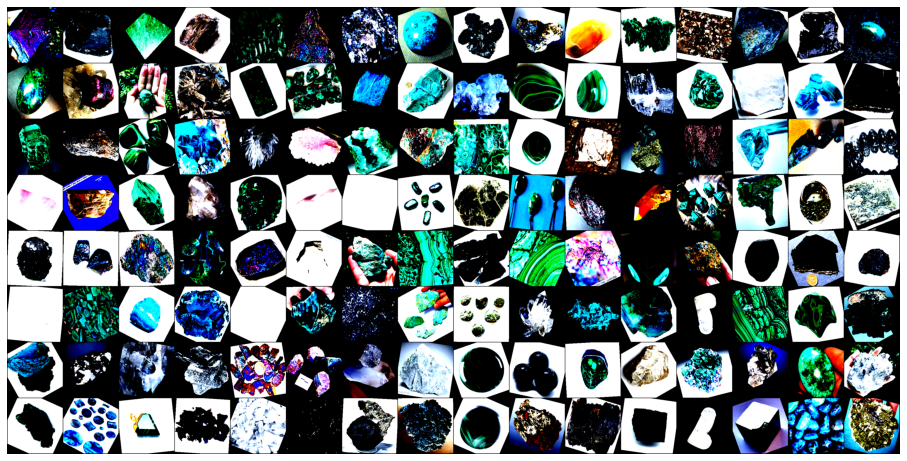

In [0]:
#check image in trainloader for one batch
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

# Build Model

In [0]:
w1 = 20
F_SIZE= 3
F_POOL = 3
P = 0
S_SIZE = 1
S_POOL = 3

SIZE = (w1 - F_SIZE + 2*P)/S_SIZE+1
POOL = (SIZE - F_POOL)/S_POOL+1
w1 = POOL
print(SIZE)
w1

In [0]:
6*6*64

## My own model

In [0]:
class Mineral_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 48, 11, stride=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1), #out 70x70

            nn.Conv2d(48, 128, 5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 1),#out 64x64

            nn.Conv2d(128, 128, 4, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(4, 3),#out 20x20

            nn.Conv2d(128, 64, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),#out 20x20

            nn.Flatten(),
            nn.Linear(64*6*6, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 7),
            nn.LogSoftmax(dim=1),
            )
        
    def forward(self, x):
        out = self.net(x)
        return out

model_1 = Mineral_1()
model_1.to(device)
model_1

Mineral_1(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax()
  )
)

In [0]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    train_losses = []
    test_losses = []
    train_accu = []
    val_accu = []
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        train_acc = 0
        for image, label in train_loader:
            optimizer.zero_grad()
            image = image.to(device); label = label.to(device);

            output = model(image)
            ps = torch.exp(output)
            _, top_class = ps.topk(1, dim=1)
            correct = top_class == label.view(*top_class.shape)
            train_acc += torch.mean(correct.type(torch.FloatTensor))

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                for image, label in val_loader:
                    image = image.to(device); label = label.to(device);

                    output = model(image)
                    loss = criterion(output, label)

                    ps = torch.exp(output)
                    _, top_class = ps.topk(1, dim=1)
                    correct = top_class == label.view(*top_class.shape)
                    accuracy += torch.mean(correct.type(torch.FloatTensor))

                    test_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            train_accu.append(train_acc/len(train_loader))
            val_accu.append(accuracy/len(val_loader))
            model.train()
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Train Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(val_loader)),
                  "Train Accuracy: {:.3f}.. ".format(train_acc/len(train_loader)),
                  "Test Accuracy: {:.3f}.. ".format(accuracy/len(val_loader)),
                  "Time: {:.2f}s" .format((time.time()-since)))
    
    history = {'train_loss' : train_losses, 'val_loss': test_losses, 
               'train_accuracy': train_accu, 'val_accuracy':val_accu}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [0]:
#saving model
def save_model(model, optim, fpath):
    checkpoint = {'model' : model,
                'state_dict': model.state_dict(),
                'optim' : optim.state_dict()
                }

    torch.save(checkpoint, fpath)

#load model
def load_model(fpath):
    check = torch.load(fpath)
    model = check['model']
    model.load_state_dict(check['state_dict'])
    # if inferece:
    #     for param in model.parameters():
    #         param.requires_grad = False
    #     model.eval()
    # else:
    #     model.train()
    return model

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.0001)
epoch = 30
history_mineral = fit(epoch, model_1, train_loader, val_loader, criterion, optimizer)

Epoch: 1/30..  Train Loss: 1.912..  Test Loss: 1.818..  Train Accuracy: 0.206..  Test Accuracy: 0.250..  Time: 18.58s
Epoch: 2/30..  Train Loss: 1.761..  Test Loss: 1.612..  Train Accuracy: 0.281..  Test Accuracy: 0.417..  Time: 18.13s
Epoch: 3/30..  Train Loss: 1.528..  Test Loss: 1.292..  Train Accuracy: 0.418..  Test Accuracy: 0.438..  Time: 18.65s
Epoch: 4/30..  Train Loss: 1.332..  Test Loss: 1.053..  Train Accuracy: 0.478..  Test Accuracy: 0.521..  Time: 18.87s
Epoch: 5/30..  Train Loss: 1.199..  Test Loss: 0.947..  Train Accuracy: 0.539..  Test Accuracy: 0.646..  Time: 18.08s
Epoch: 6/30..  Train Loss: 1.117..  Test Loss: 0.880..  Train Accuracy: 0.559..  Test Accuracy: 0.667..  Time: 18.08s
Epoch: 7/30..  Train Loss: 1.031..  Test Loss: 0.783..  Train Accuracy: 0.590..  Test Accuracy: 0.708..  Time: 18.11s
Epoch: 8/30..  Train Loss: 0.980..  Test Loss: 0.747..  Train Accuracy: 0.651..  Test Accuracy: 0.667..  Time: 18.25s
Epoch: 9/30..  Train Loss: 0.929..  Test Loss: 0.762..  

In [0]:
#save mode
save_model(model_1, optimizer, '/content/drive/My Drive/Colab Notebooks/mineral/minet/mineral_seq_own.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Mineral_1. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


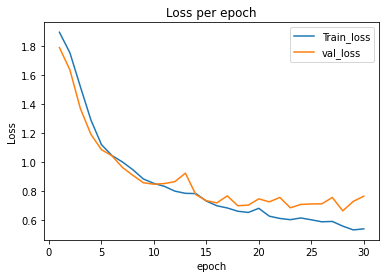

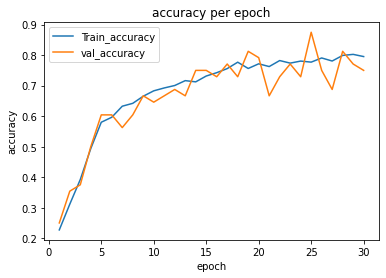

In [0]:
def plot_loss(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_loss'], label='Train_loss')
    plt.plot(epoch, history['val_loss'], label='val_loss')
    plt.title('Loss per epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(); 
    plt.show()

def plot_accuracy(history, n_epoch):
    epoch = [x for x in range(1, n_epoch+1)]
    plt.plot(epoch, history['train_accuracy'], label='Train_accuracy')
    plt.plot(epoch, history['val_accuracy'], label='val_accuracy')
    plt.title('accuracy per epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(); 
    plt.show()
plot_loss(history_mineral, epoch)
plot_accuracy(history_mineral, epoch)

## Pre-trained mode

In [0]:
from torchvision import models

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelVGG = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in modelVGG.parameters():
    param.requires_grad = False

#vgg16
modelVGG.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.5),
                                 nn.Linear(in_features=4096, out_features=1000),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.5),
                                 nn.Linear(in_features=1000, out_features=500),
                                 nn.Linear(500, 7),
                                 nn.LogSoftmax(dim=1))

#vgg19
# model.classifier = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
#                                  nn.ReLU(inplace=True),
#                                  nn.Dropout(p=0.5, inplace=False),
#                                  nn.Linear(in_features=4096, out_features=4096, bias=True),
#                                  nn.ReLU(inplace=True),
#                                  nn.Dropout(p=0.5, inplace=False),
#                                  nn.Linear(in_features=4096, out_features=7, bias=True),
#                                  nn.LogSoftmax(dim=1))



modelVGG.to(device);
modelVGG.train()
modelVGG

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(modelVGG.classifier.parameters(), lr=0.0001)
epoch = 30
history_VGG = fit(epoch, modelVGG, train_loader, val_loader, criterion, optimizer)

Epoch: 1/30..  Train Loss: 1.761..  Test Loss: 1.467..  Train Accuracy: 0.295..  Test Accuracy: 0.521..  Time: 20.26s
Epoch: 2/30..  Train Loss: 1.314..  Test Loss: 1.059..  Train Accuracy: 0.563..  Test Accuracy: 0.667..  Time: 20.30s
Epoch: 3/30..  Train Loss: 0.935..  Test Loss: 1.072..  Train Accuracy: 0.681..  Test Accuracy: 0.688..  Time: 20.13s
Epoch: 4/30..  Train Loss: 0.788..  Test Loss: 0.980..  Train Accuracy: 0.702..  Test Accuracy: 0.688..  Time: 20.27s
Epoch: 5/30..  Train Loss: 0.603..  Test Loss: 0.724..  Train Accuracy: 0.770..  Test Accuracy: 0.750..  Time: 19.97s
Epoch: 6/30..  Train Loss: 0.527..  Test Loss: 0.581..  Train Accuracy: 0.810..  Test Accuracy: 0.812..  Time: 20.45s
Epoch: 7/30..  Train Loss: 0.431..  Test Loss: 0.799..  Train Accuracy: 0.855..  Test Accuracy: 0.729..  Time: 20.59s
Epoch: 8/30..  Train Loss: 0.387..  Test Loss: 0.680..  Train Accuracy: 0.864..  Test Accuracy: 0.708..  Time: 19.69s
Epoch: 9/30..  Train Loss: 0.342..  Test Loss: 0.839..  

In [0]:
save_model(modelVGG,  optimizer, '/content/drive/My Drive/Colab Notebooks/mineral/minet/mineral_vgg.pth')

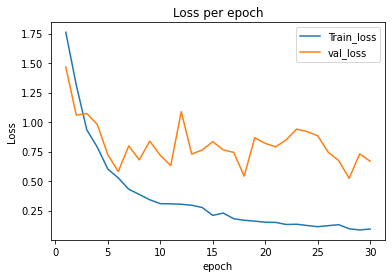

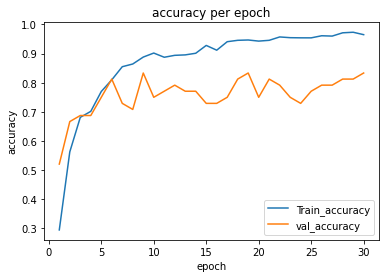

In [0]:
plot_loss(history_VGG, epoch)
plot_accuracy(history_VGG, epoch)

# Prediction and Evaluation

In [0]:
def predict_label(model, dataloader):
    model.eval()
    prediction_list = []
    labels = []
    model.to(device)
    for i, batch in enumerate(dataloader):

        image, label = batch
        image = image.to(device); 
        label = label.to(device)

        out = model(image)
        ps = torch.exp(out)
        _, top_class = torch.max(ps , 1)
        preds = np.squeeze(top_class.cpu().numpy())
        prediction_list.append(preds)
        labels.append(label.cpu().numpy())
    return np.squeeze(prediction_list), np.squeeze(labels)

In [0]:
def predict_plot(test_loader, model, target_label=target_label, n=20):

    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        images = images.cuda()

    model.eval()
    # get sample outputs
    model.to(device)
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy()) #np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
    images = images.cpu()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(n):
        ax = fig.add_subplot(2, n/2, idx+1, xticks=[], yticks=[])
        plt.imshow(images[idx].permute(1 ,2, 0))
        ax.set_title("{} ({})".format(target_label[preds[idx]], target_label[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    plt.show()

## My Model 

In [0]:
model_mineral = load_model('/content/drive/My Drive/Colab Notebooks/mineral/minet/mineral_seq_own.pth')
model_mineral

Mineral_1(
  (net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=2304, out_features=512, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=7, bias=True)
    (17): LogSoftmax()
  )
)

In [0]:
#how model perfome in test_data
y_predict, y_true = predict_label(model_mineral, test_loader)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.71      0.62      0.67         8
           2       0.78      0.88      0.82         8
           3       0.91      0.91      0.91        11
           4       0.67      0.50      0.57         4
           5       0.67      0.80      0.73         5
           6       0.86      0.86      0.86         7

    accuracy                           0.80        46
   macro avg       0.80      0.80      0.79        46
weighted avg       0.80      0.80      0.80        46



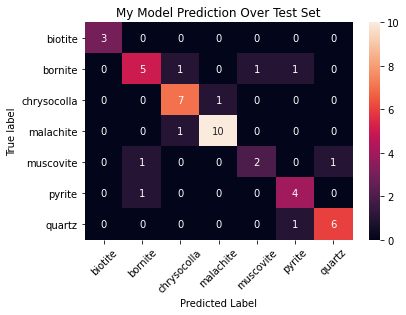

In [0]:
#plot confusion matric
print(classification_report(y_true, y_predict))
sns.heatmap(confusion_matrix(y_true, y_predict), annot=True)
plt.ylabel('True label'); plt.xlabel('Predicted Label')
plt.yticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=0);
plt.xticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=45)
plt.title('My Model Prediction Over Test Set')
plt.show()

## VGG Model

In [0]:
model_vgg = load_model('/content/drive/My Drive/Colab Notebooks/mineral/minet/mineral_vgg.pth')

In [0]:
#how model perfome in test_data
y_predict_vgg, y_true_vgg = predict_label(model_vgg, test_loader)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.90      1.00      0.95         9
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         4
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         7

    accuracy                           0.96        48
   macro avg       0.95      0.95      0.95        48
weighted avg       0.97      0.96      0.96        48



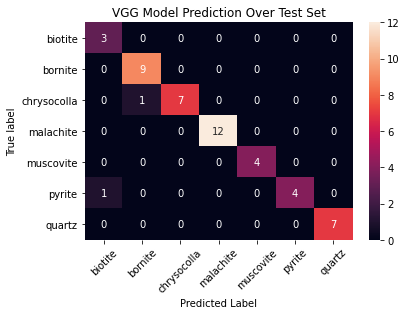

In [0]:
#plot confusion matric
print(classification_report(y_true_vgg, y_predict_vgg))
sns.heatmap(confusion_matrix(y_true_vgg, y_predict_vgg), annot=True)
plt.ylabel('True label'); plt.xlabel('Predicted Label')
plt.yticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=0);
plt.xticks(np.arange(0.5, len(target_label)), labels=target_label, rotation=45)
plt.title('VGG Model Prediction Over Test Set')
plt.show()

## Plot Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

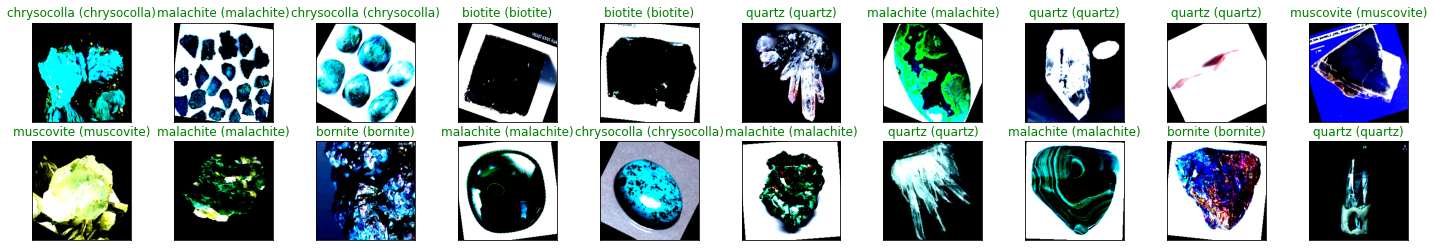

In [0]:
predict_plot(test_loader, model_vgg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

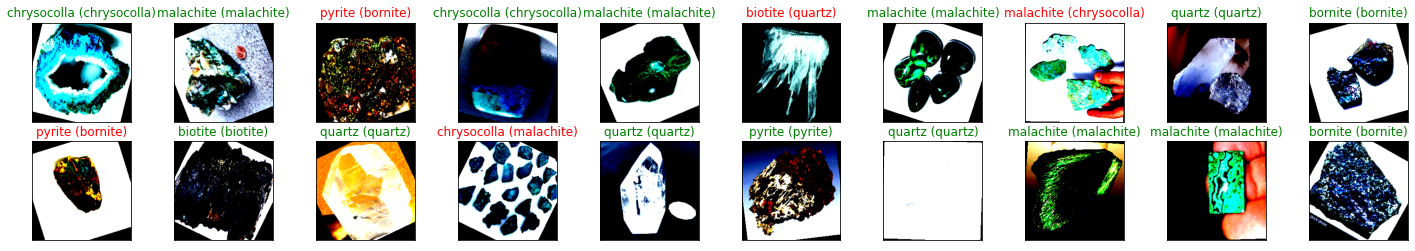

In [0]:
predict_plot(test_loader, model_mineral)

# Interactive Prediction Using Image URL


In [0]:
def predict_img(model, image):
    model.eval()
    model.to(device)

    imsize = (224, 224)
    loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])
    image = loader(image)
    image = image.unsqueeze(0) 
    
    image = image.to(device); 
    out = model(image)
    ps = torch.exp(out)
    _, top_class = torch.max(ps , 1)
    preds = np.squeeze(top_class.cpu().numpy())

    return target_label[preds]

https://2.bp.blogspot.com/-8MJK8XlQvO0/U3wbIwTRMWI/AAAAAAAAC_0/6a2vkk8x8vo/s1600/peacock+ore.jpg


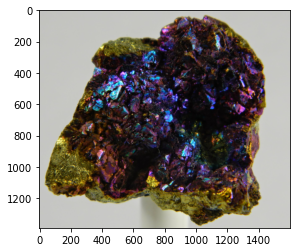

In [0]:
#only predict for this classes
target_label = ['biotite', 'bornite', 'chrysocolla', 'malachite', 
                'muscovite', 'pyrite', 'quartz']

#input picture has to be at least 224x224 to avoid size mismatch
url = input()
response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [0]:
predict_img(model_vgg, img) #vgg pretrained

'bornite'

In [0]:
predict_img(model_mineral, img) #my model

'bornite'